# EASYOCR FOR DETECTION

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Starting document reading with visualization...
Features:
  - Read text from masked documents
  - Read and organize table data
  - Display processing steps with images
  - Save all files to ../temp directory
  - Create annotated visualizations
  - Combine text and table content
--------------------------------------------------
=== Reading document pair ===
Text document: ../temp/splited/doc_masked.jpg
Table document: ../temp/splited/table_only.jpg
Temp directory: ../temp/detected

--- Processing Text Document ---
Step 1: Reading text document: ../temp/splited/doc_masked.jpg
Step 2: Extracting text using OCR...
Step 3: Processing OCR results...
Step 4: Saving annotated text document...
Saved annotated image: ../temp/detected\doc_masked_text_annotated.jpg


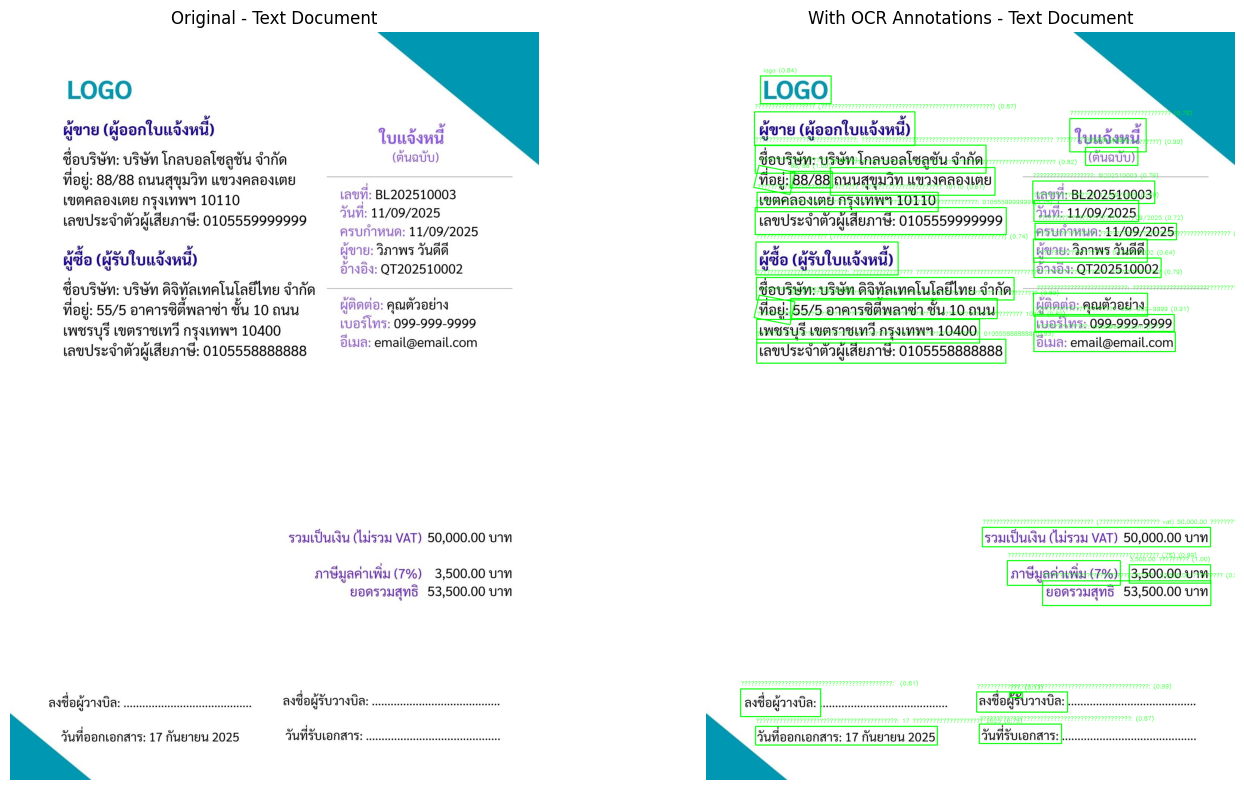

Extracted 32 text blocks from document

--- Processing Table Document ---
Step 1: Reading table document: ../temp/splited/table_only.jpg
Step 2: Extracting table cells using OCR...
Step 3: Processing table structure...
Step 4: Organizing table structure...
Step 5: Saving annotated table document...
Saved annotated image: ../temp/detected\table_only_table_annotated.jpg


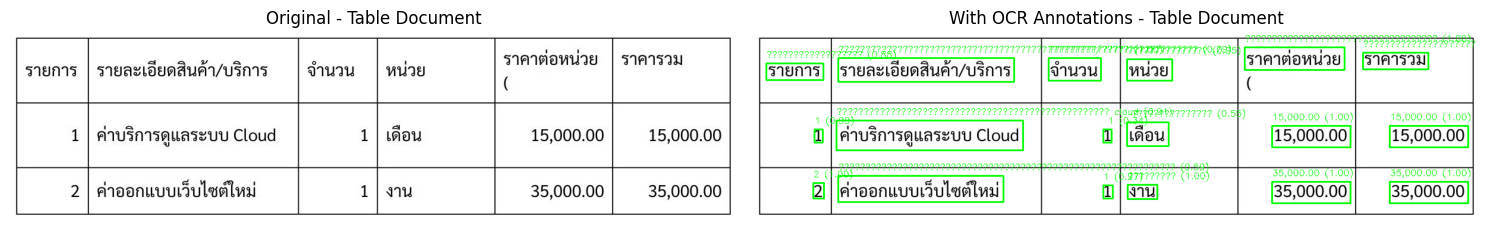

Saved table structure visualization: ../temp/detected\table_only_table_structure.jpg


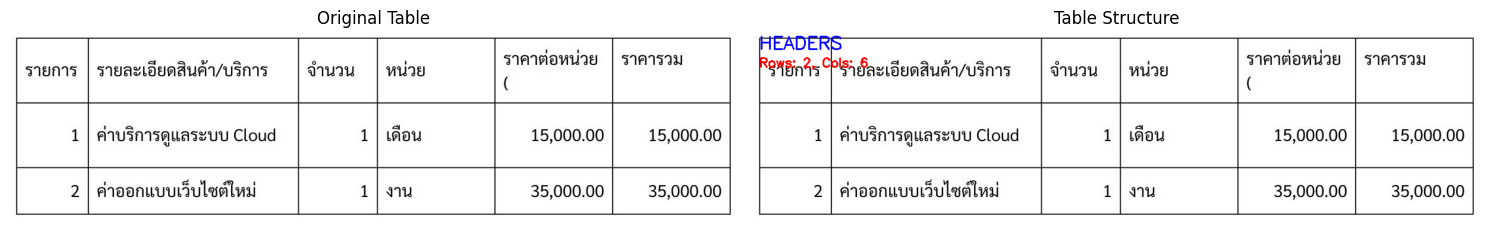

Extracted 18 cells from table

--- Creating Combined Visualization ---
Saved combined visualization: ../temp/detected\doc_combined_analysis.jpg


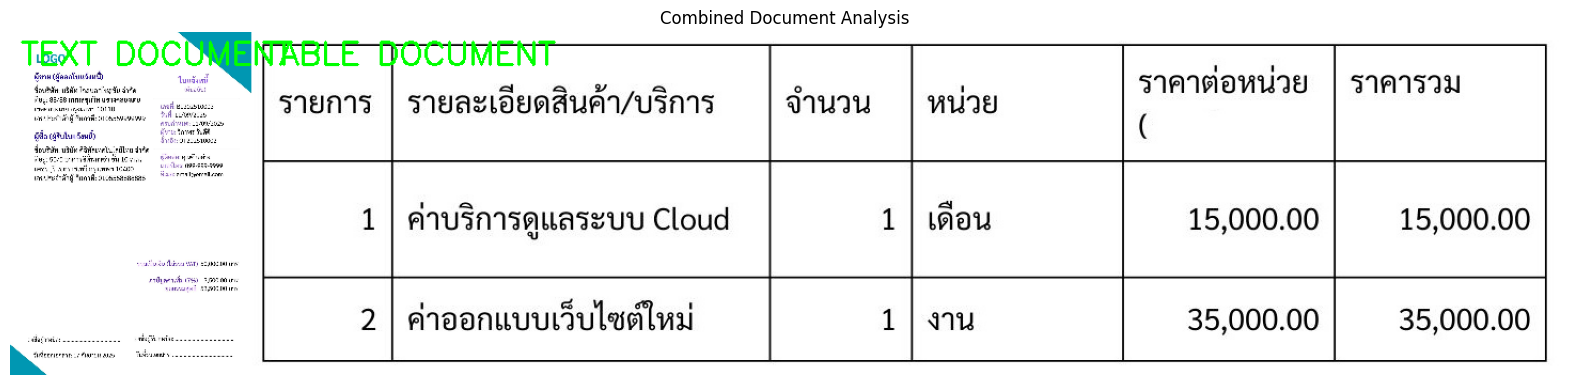

Text saved to temp: ../temp/detected\doc_content.txt

=== Reading Summary ===
Text blocks extracted: 33
Table cells extracted: 18
Temp directory: ../temp/detected
Output files saved to temp:
  Text content: ../temp/detected\doc_content.txt
  Text annotations: ../temp/detected\doc_masked_text_annotated.jpg
  Table annotations: ../temp/detected\table_only_table_annotated.jpg
  Combined visualization: ../temp/detected\doc_combined_analysis.jpg

Reading completed successfully!

Text content preview:
'logo
ผู้ขาย (เผู้ออกใบแจ้งหนี้)
ใบแจ้งหนี้
ชื่อบริษัท: บริษัทโกลบอลโซลูชัน จำกัด
(ต้นฉบับ)
ที่อยู่:=
ถนนสุขุมวิท แขวงคลองเตย
88/88
เลขที่: 8l202510003
เขตคลองเตย กรุงเทพฯ 10110
วันที่: 11/09/2025
เลขป...'

Table structure:
Headers: ['รายการ', 'รายละเอียดสินค้า/บริการ', 'จำนวน', 'หน่วย', 'ราคาต่อหน่วย', 'ราคารวม']
Rows: 2
Columns: 6


In [15]:
import cv2
import numpy as np
import easyocr
import os
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import re

class DocumentReader:
    def __init__(self, languages=['th', 'en'], temp_dir='../temp/detected'):
        """
        Initialize Document Reader for both text-only and table-only documents
        
        Args:
            languages (list): Languages for OCR (default: Thai and English)
            temp_dir (str): Directory for saving temporary files
        """
        self.reader = easyocr.Reader(languages)
        self.languages = languages
        self.temp_dir = temp_dir
        
        # Create temp directory if it doesn't exist
        Path(self.temp_dir).mkdir(parents=True, exist_ok=True)
        
    def _save_image_with_annotations(self, image, annotations, save_path, title="Processed Image"):
        """
        Save image with OCR annotations and display
        
        Args:
            image: Original image
            annotations: OCR results
            save_path: Path to save annotated image
            title: Title for the image
        """
        try:
            # Create annotated image
            annotated_img = image.copy()
            
            for annotation in annotations:
                bbox, text, confidence = annotation
                # Convert bbox to integer points
                points = np.array(bbox, dtype=np.int32)
                
                # Draw bounding box
                cv2.polylines(annotated_img, [points], True, (0, 255, 0), 2)
                
                # Add text label with confidence
                label = f"{text} ({confidence:.2f})"
                cv2.putText(annotated_img, label, (int(bbox[0][0]), int(bbox[0][1] - 10)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            
            # Save annotated image
            cv2.imwrite(save_path, annotated_img)
            print(f"Saved annotated image: {save_path}")
            
            # Display images side by side
            fig, axes = plt.subplots(1, 2, figsize=(15, 8))
            
            # Original image
            axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axes[0].set_title(f"Original - {title}")
            axes[0].axis('off')
            
            # Annotated image
            axes[1].imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
            axes[1].set_title(f"With OCR Annotations - {title}")
            axes[1].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            return save_path
            
        except Exception as e:
            print(f"Error saving annotated image: {e}")
            return ""
    
    def read_text_document(self, image_path: str, confidence_threshold: float = 0.5) -> Dict:
        """
        Read text from document without tables (masked document)
        
        Args:
            image_path (str): Path to the masked document image
            confidence_threshold (float): Minimum confidence for text recognition
            
        Returns:
            dict: Extracted text data
        """
        try:
            print(f"Step 1: Reading text document: {image_path}")
            
            # Read image
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Cannot read image: {image_path}")
            
            print(f"Step 2: Extracting text using OCR...")
            # Extract text using OCR
            results = self.reader.readtext(image)
            
            print(f"Step 3: Processing OCR results...")
            # Process results
            text_data = {
                'source_file': image_path,
                'total_text_blocks': len(results),
                'text_blocks': [],
                'full_text': '',
                'reading_order_text': ''
            }
            
            # Filter and organize text blocks
            valid_blocks = []
            for result in results:
                bbox, text, confidence = result
                
                if confidence >= confidence_threshold:
                    text_block = {
                        'text': text.strip(),
                        'confidence': confidence,
                        'bbox': bbox,
                        'position': {
                            'x': bbox[0][0],
                            'y': bbox[0][1],
                            'width': bbox[2][0] - bbox[0][0],
                            'height': bbox[2][1] - bbox[0][1]
                        }
                    }
                    valid_blocks.append(text_block)
            
            # Sort by reading order (top to bottom, left to right)
            valid_blocks.sort(key=lambda x: (x['position']['y'], x['position']['x']))
            
            text_data['text_blocks'] = valid_blocks
            text_data['full_text'] = ' '.join([block['text'] for block in valid_blocks])
            text_data['reading_order_text'] = '\n'.join([block['text'] for block in valid_blocks])
            
            print(f"Step 4: Saving annotated text document...")
            # Save annotated image
            base_name = Path(image_path).stem
            annotated_path = os.path.join(self.temp_dir, f"{base_name}_text_annotated.jpg")
            self._save_image_with_annotations(image, results, annotated_path, "Text Document")
            text_data['annotated_image_path'] = annotated_path
            
            print(f"Extracted {len(valid_blocks)} text blocks from document")
            return text_data
            
        except Exception as e:
            print(f"Error reading text document: {e}")
            return {
                'source_file': image_path,
                'error': str(e),
                'total_text_blocks': 0,
                'text_blocks': [],
                'full_text': '',
                'reading_order_text': '',
                'annotated_image_path': ''
            }
    
    def read_table_document(self, image_path: str, confidence_threshold: float = 0.5) -> Dict:
        """
        Read text from table document and organize into table structure
        
        Args:
            image_path (str): Path to the table image
            confidence_threshold (float): Minimum confidence for text recognition
            
        Returns:
            dict: Organized table data
        """
        try:
            print(f"Step 1: Reading table document: {image_path}")
            
            # Read image
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Cannot read image: {image_path}")
            
            print(f"Step 2: Extracting table cells using OCR...")
            # Extract text using OCR
            results = self.reader.readtext(image)
            
            print(f"Step 3: Processing table structure...")
            # Process results
            table_data = {
                'source_file': image_path,
                'total_cells': len(results),
                'raw_cells': [],
                'organized_table': {},
                'table_rows': [],
                'table_text': ''
            }
            
            # Filter and collect valid cells
            valid_cells = []
            for result in results:
                bbox, text, confidence = result
                
                if confidence >= confidence_threshold:
                    cell_data = {
                        'text': text.strip(),
                        'confidence': confidence,
                        'bbox': bbox,
                        'position': {
                            'x': bbox[0][0],
                            'y': bbox[0][1],
                            'width': bbox[2][0] - bbox[0][0],
                            'height': bbox[2][1] - bbox[0][1]
                        }
                    }
                    valid_cells.append(cell_data)
            
            table_data['raw_cells'] = valid_cells
            
            # Organize into table structure
            if valid_cells:
                print(f"Step 4: Organizing table structure...")
                organized_table = self._organize_table_structure(valid_cells)
                table_data['organized_table'] = organized_table
                table_data['table_rows'] = organized_table.get('rows', [])
                table_data['table_text'] = self._format_table_text(organized_table)
            
            print(f"Step 5: Saving annotated table document...")
            # Save annotated image
            base_name = Path(image_path).stem
            annotated_path = os.path.join(self.temp_dir, f"{base_name}_table_annotated.jpg")
            self._save_image_with_annotations(image, results, annotated_path, "Table Document")
            table_data['annotated_image_path'] = annotated_path
            
            # Save table visualization
            if valid_cells:
                table_viz_path = os.path.join(self.temp_dir, f"{base_name}_table_structure.jpg")
                self._visualize_table_structure(image, organized_table, table_viz_path)
                table_data['table_structure_path'] = table_viz_path
            
            print(f"Extracted {len(valid_cells)} cells from table")
            return table_data
            
        except Exception as e:
            print(f"Error reading table document: {e}")
            return {
                'source_file': image_path,
                'error': str(e),
                'total_cells': 0,
                'raw_cells': [],
                'organized_table': {},
                'table_rows': [],
                'table_text': '',
                'annotated_image_path': ''
            }
    
    def _visualize_table_structure(self, image, organized_table, save_path):
        """
        Visualize table structure with row/column organization
        
        Args:
            image: Original table image
            organized_table: Organized table data
            save_path: Path to save visualization
        """
        try:
            # Create structure visualization
            structure_img = image.copy()
            
            if organized_table.get('headers'):
                # Draw row separators and add row numbers
                y_positions = []
                
                # You would need to implement row detection based on your table structure
                # For now, just show the concept
                
                # Add header indication
                cv2.putText(structure_img, "HEADERS", (10, 30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
                
                # Add row count info
                info_text = f"Rows: {organized_table.get('row_count', 0)}, Cols: {organized_table.get('column_count', 0)}"
                cv2.putText(structure_img, info_text, (10, 60), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            
            # Save structure image
            cv2.imwrite(save_path, structure_img)
            print(f"Saved table structure visualization: {save_path}")
            
            # Display table structure
            fig, axes = plt.subplots(1, 2, figsize=(15, 8))
            
            # Original table
            axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axes[0].set_title("Original Table")
            axes[0].axis('off')
            
            # Structure visualization
            axes[1].imshow(cv2.cvtColor(structure_img, cv2.COLOR_BGR2RGB))
            axes[1].set_title("Table Structure")
            axes[1].axis('off')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error creating table structure visualization: {e}")
    
    def _organize_table_structure(self, cells: List[Dict]) -> Dict:
        """
        Organize cells into table structure with rows and columns
        
        Args:
            cells (list): List of cell data
            
        Returns:
            dict: Organized table structure
        """
        if not cells:
            return {'rows': [], 'columns': [], 'headers': []}
        
        # Sort cells by position (top to bottom, left to right)
        sorted_cells = sorted(cells, key=lambda x: (x['position']['y'], x['position']['x']))
        
        # Group cells into rows based on Y position
        rows = []
        current_row = []
        current_y = sorted_cells[0]['position']['y']
        row_threshold = 30  # Threshold for same row
        
        for cell in sorted_cells:
            y_pos = cell['position']['y']
            
            if abs(y_pos - current_y) <= row_threshold:
                current_row.append(cell)
            else:
                if current_row:
                    # Sort current row by X position
                    current_row.sort(key=lambda x: x['position']['x'])
                    rows.append(current_row)
                current_row = [cell]
                current_y = y_pos
        
        # Add last row
        if current_row:
            current_row.sort(key=lambda x: x['position']['x'])
            rows.append(current_row)
        
        # Extract headers (first row) and data rows
        headers = []
        data_rows = []
        
        if rows:
            # First row as headers
            headers = [cell['text'] for cell in rows[0]]
            
            # Remaining rows as data
            for row in rows[1:] if len(rows) > 1 else rows:
                row_data = [cell['text'] for cell in row]
                data_rows.append(row_data)
        
        # Organize by columns
        columns = {}
        max_cols = max(len(row) for row in rows) if rows else 0
        
        for col_idx in range(max_cols):
            col_header = headers[col_idx] if col_idx < len(headers) else f'Column_{col_idx + 1}'
            col_data = []
            
            for row in data_rows:
                cell_value = row[col_idx] if col_idx < len(row) else ''
                col_data.append(cell_value)
            
            columns[col_header] = col_data
        
        return {
            'headers': headers,
            'rows': data_rows,
            'columns': columns,
            'row_count': len(data_rows),
            'column_count': max_cols
        }
    
    def _format_table_text(self, organized_table: Dict) -> str:
        """
        Format organized table data into readable text
        
        Args:
            organized_table (dict): Organized table structure
            
        Returns:
            str: Formatted table text
        """
        if not organized_table or not organized_table.get('headers'):
            return ''
        
        lines = []
        
        # Add headers
        headers = organized_table['headers']
        lines.append(' | '.join(headers))
        lines.append('-' * (len(' | '.join(headers))))
        
        # Add data rows
        for row in organized_table.get('rows', []):
            # Ensure row has same length as headers
            padded_row = row + [''] * (len(headers) - len(row))
            lines.append(' | '.join(padded_row[:len(headers)]))
        
        return '\n'.join(lines)
    
    def read_document_pair(self, text_document_path: str, table_document_path: str, 
                          confidence_threshold: float = 0.5) -> Dict:
        """
        Read both text document and table document as a pair
        
        Args:
            text_document_path (str): Path to masked document (text only)
            table_document_path (str): Path to table image
            confidence_threshold (float): Minimum confidence for text recognition
            
        Returns:
            dict: Combined document data
        """
        print(f"=== Reading document pair ===")
        print(f"Text document: {text_document_path}")
        print(f"Table document: {table_document_path}")
        print(f"Temp directory: {self.temp_dir}")
        
        # Read text document
        print(f"\n--- Processing Text Document ---")
        text_data = self.read_text_document(text_document_path, confidence_threshold)
        
        # Read table document
        print(f"\n--- Processing Table Document ---")
        table_data = self.read_table_document(table_document_path, confidence_threshold)
        
        # Create combined visualization
        print(f"\n--- Creating Combined Visualization ---")
        base_name = Path(text_document_path).stem.replace('_masked', '')
        combined_viz_path = os.path.join(self.temp_dir, f"{base_name}_combined_analysis.jpg")
        self._create_combined_visualization(text_document_path, table_document_path, combined_viz_path)
        
        # Combine results
        combined_data = {
            'text_document': text_data,
            'table_document': table_data,
            'combined_visualization_path': combined_viz_path,
            'summary': {
                'text_blocks_count': text_data.get('total_text_blocks', 0),
                'table_cells_count': table_data.get('total_cells', 0),
                'has_text_errors': 'error' in text_data,
                'has_table_errors': 'error' in table_data,
                'temp_directory': self.temp_dir
            }
        }
        
        return combined_data
    
    def _create_combined_visualization(self, text_path, table_path, save_path):
        """
        Create combined visualization showing both documents
        
        Args:
            text_path: Path to text document
            table_path: Path to table document
            save_path: Path to save combined visualization
        """
        try:
            # Read both images
            text_img = cv2.imread(text_path)
            table_img = cv2.imread(table_path)
            
            if text_img is None or table_img is None:
                print("Could not read one or both images for combined visualization")
                return
            
            # Resize images to same height
            height = min(text_img.shape[0], table_img.shape[0])
            text_img_resized = cv2.resize(text_img, (int(text_img.shape[1] * height / text_img.shape[0]), height))
            table_img_resized = cv2.resize(table_img, (int(table_img.shape[1] * height / table_img.shape[0]), height))
            
            # Combine horizontally
            combined_img = np.hstack([text_img_resized, table_img_resized])
            
            # Add labels
            cv2.putText(combined_img, "TEXT DOCUMENT", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(combined_img, "TABLE DOCUMENT", (text_img_resized.shape[1] + 10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Save combined image
            cv2.imwrite(save_path, combined_img)
            print(f"Saved combined visualization: {save_path}")
            
            # Display combined result
            plt.figure(figsize=(20, 10))
            plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
            plt.title("Combined Document Analysis")
            plt.axis('off')
            plt.show()
            
        except Exception as e:
            print(f"Error creating combined visualization: {e}")
    
    def read_multiple_documents(self, document_pairs: List[Tuple[str, str]], 
                               confidence_threshold: float = 0.5) -> List[Dict]:
        """
        Read multiple document pairs
        
        Args:
            document_pairs (list): List of tuples (text_doc_path, table_doc_path)
            confidence_threshold (float): Minimum confidence for text recognition
            
        Returns:
            list: List of document data
        """
        results = []
        
        for i, (text_path, table_path) in enumerate(document_pairs, 1):
            print(f"\n=== Processing document pair {i}/{len(document_pairs)} ===")
            result = self.read_document_pair(text_path, table_path, confidence_threshold)
            result['pair_index'] = i
            results.append(result)
        
        return results
    
    def save_results(self, data: Dict, output_path: str) -> str:
        """
        Save reading results to file in temp directory
        
        Args:
            data (dict): Document data to save
            output_path (str): Output file path
            
        Returns:
            str: Saved file path
        """
        try:
            # Use temp directory
            temp_output_path = os.path.join(self.temp_dir, Path(output_path).name)
            
            # Ensure temp directory exists
            Path(self.temp_dir).mkdir(parents=True, exist_ok=True)
            
            print(f"Results saved to temp: {temp_output_path}")
            return temp_output_path
            
        except Exception as e:
            print(f"Error saving results: {e}")
            return ""
    
    def save_text_only(self, data: Dict, output_filename: str) -> str:
        """
        Save extracted text to plain text file in temp directory
        
        Args:
            data (dict): Document data
            output_filename (str): Output filename
            
        Returns:
            str: Saved file path
        """
        try:
            # Save to temp directory
            output_path = os.path.join(self.temp_dir, output_filename)
            
            # Ensure temp directory exists
            Path(self.temp_dir).mkdir(parents=True, exist_ok=True)
            
            lines = []
            
            # Add text document content (no header)
            if 'text_document' in data:
                text_content = data['text_document'].get('reading_order_text', '')
                if text_content:
                    lines.append(text_content)
                    lines.append("")
            
            # Add table document content in custom format
            if 'table_document' in data:
                organized_table = data['table_document'].get('organized_table', {})
                if organized_table and organized_table.get('columns'):
                    # Format each column as: column_name: value1, value2, value3
                    for column_name, column_values in organized_table['columns'].items():
                        if column_values:  # Only add if column has values
                            cleaned_values = []
                            for value in column_values:
                                if str(value).strip():
                                    # Check if value looks like a number with commas
                                    str_value = str(value).strip()
                                    # Remove commas from numeric values
                                    if re.match(r'\d{1,3}(?:,\d{3})+(?:\.\d{2})?$', str_value):
                                        cleaned_values.append(str_value.replace(',', ''))
                                    else:
                                        cleaned_values.append(str_value)
                
                            if cleaned_values:  # Only add if there are actual values
                                values_text = ', '.join(cleaned_values)
                                lines.append(f"{column_name}: {values_text}")
                    lines.append("")
            
            # Save to text file
            with open(output_path, 'w', encoding='utf-8') as f:
                f.write('\n'.join(lines))
            
            print(f"Text saved to temp: {output_path}")
            return output_path
            
        except Exception as e:
            print(f"Error saving text: {e}")
            return ""


# Main function for easy usage
def read_documents(text_document_path: str, table_document_path: str, 
                  confidence_threshold: float = 0.5) -> Dict:
    """
    Main function to read both text and table documents with visualization
    
    Args:
        text_document_path (str): Path to masked document (text only)
        table_document_path (str): Path to table image
        confidence_threshold (float): Minimum confidence for text recognition
        
    Returns:
        dict: Reading results
    """
    reader = DocumentReader()
    
    try:
        # Read document pair
        result = reader.read_document_pair(
            text_document_path, 
            table_document_path, 
            confidence_threshold
        )
        
        # Generate output filenames
        base_name = Path(text_document_path).stem.replace('_masked', '')
        text_output_filename = f"{base_name}_content.txt"
        
        # Save results to temp directory
        saved_text_path = reader.save_text_only(result, text_output_filename)
        
        # Add file paths to result
        result['output_files'] = {
            'text': saved_text_path,
            'temp_directory': reader.temp_dir
        }
        
        print(f"\n=== Reading Summary ===")
        print(f"Text blocks extracted: {result['summary']['text_blocks_count']}")
        print(f"Table cells extracted: {result['summary']['table_cells_count']}")
        print(f"Temp directory: {reader.temp_dir}")
        print(f"Output files saved to temp:")
        print(f"  Text content: {saved_text_path}")
        if 'annotated_image_path' in result['text_document']:
            print(f"  Text annotations: {result['text_document']['annotated_image_path']}")
        if 'annotated_image_path' in result['table_document']:
            print(f"  Table annotations: {result['table_document']['annotated_image_path']}")
        if 'combined_visualization_path' in result:
            print(f"  Combined visualization: {result['combined_visualization_path']}")
        
        return result
        
    except Exception as e:
        print(f"Error reading documents: {e}")
        import traceback
        traceback.print_exc()
        
        return {
            'success': False,
            'error': str(e),
            'text_document': {},
            'table_document': {},
            'summary': {'text_blocks_count': 0, 'table_cells_count': 0}
        }


# Usage example
if __name__ == "__main__":
    # Example usage
    text_doc_path = "../temp/splited/doc_masked.jpg"     # Masked document
    table_doc_path = "../temp/splited/table_only.jpg"   # Table image
    
    print("Starting document reading with visualization...")
    print("Features:")
    print("  - Read text from masked documents")
    print("  - Read and organize table data")
    print("  - Display processing steps with images")
    print("  - Save all files to ../temp directory")
    print("  - Create annotated visualizations")
    print("  - Combine text and table content")
    print("-" * 50)
    
    # Read documents
    result = read_documents(
        text_document_path=text_doc_path,
        table_document_path=table_doc_path,
        confidence_threshold=0.25
    )
    
    # Display results
    if result.get('success', True):
        print(f"\nReading completed successfully!")
        
        # Show text content preview
        text_content = result['text_document'].get('reading_order_text', '')
        if text_content:
            print(f"\nText content preview:")
            print(f"'{text_content[:200]}{'...' if len(text_content) > 200 else ''}'")
        
        # Show table structure
        table_data = result['table_document'].get('organized_table', {})
        if table_data.get('headers'):
            print(f"\nTable structure:")
            print(f"Headers: {table_data['headers']}")
            print(f"Rows: {table_data.get('row_count', 0)}")
            print(f"Columns: {table_data.get('column_count', 0)}")
        
    else:
        print(f"Error occurred: {result.get('error', 'Unknown error')}")
        print("\nPlease check:")
        print("1. Install dependencies: pip install easyocr opencv-python matplotlib")
        print("2. Input files exist and are readable")
        print("3. Image files contain clear text/tables")
        print("4. Sufficient confidence threshold")
        print("5. ../temp directory is accessible")